In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession \
    .builder \
    .appName("Python Spark OpenStreetMap project") \
    .config("spark.some.config.option", "osm-hungary") \
    .getOrCreate()

In [3]:
hungaryNodes = spark.read.parquet("parquets/hungary-latest.osm.pbf.node.parquet")
hungaryWays = spark.read.parquet("parquets/hungary-latest.osm.pbf.way.parquet")
hungaryRelations = spark.read.parquet("parquets/hungary-latest.osm.pbf.relation.parquet")

In [4]:
hungaryNodes.createOrReplaceTempView("hungaryNodes")
hungaryWays.createOrReplaceTempView("hungaryWays")
hungaryRelations.createOrReplaceTempView("hungaryRelations")

In [5]:
hungaryNodes.show(5)

+------+-------+-------------+---------+------+--------------------+----+------------------+------------------+
|    id|version|    timestamp|changeset|   uid|            user_sid|tags|          latitude|         longitude|
+------+-------+-------------+---------+------+--------------------+----+------------------+------------------+
|277282|      5|1356326500000| 14386177|740331|    [53 6B 79 6C 69]|  []|        47.5135549|19.047102000000002|
|277285|      9|1315781775000|  9276182| 15565|[6B 65 6D 70 65 6...|  []|        47.5135409|19.058013900000002|
|277286|      7|1315781775000|  9276182| 15565|[6B 65 6D 70 65 6...|  []|        47.5146097|19.058831700000002|
|277290|      3|1295212827000|  6994044| 55843|[66 6C 61 6B 74 6...|  []|        47.5166629|        19.0613926|
|277298|      6|1356326500000| 14386177|740331|    [53 6B 79 6C 69]|  []|47.514618000000006|        19.0435418|
+------+-------+-------------+---------+------+--------------------+----+------------------+------------

In [6]:
from pyspark.sql.types import TimestampType

In [7]:
hungaryNodes = hungaryNodes.withColumn('created_at', (hungaryNodes.timestamp/ 1000).cast(TimestampType()))

In [8]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

In [9]:
hungaryNodes = hungaryNodes.withColumn('user_sid', hungaryNodes['user_sid'].cast(StringType()))

In [10]:
hungaryNodes.show(5)

+------+-------+-------------+---------+------+--------+----+------------------+------------------+-------------------+
|    id|version|    timestamp|changeset|   uid|user_sid|tags|          latitude|         longitude|         created_at|
+------+-------+-------------+---------+------+--------+----+------------------+------------------+-------------------+
|277282|      5|1356326500000| 14386177|740331|   Skyli|  []|        47.5135549|19.047102000000002|2012-12-24 06:21:40|
|277285|      9|1315781775000|  9276182| 15565|kempelen|  []|        47.5135409|19.058013900000002|2011-09-12 00:56:15|
|277286|      7|1315781775000|  9276182| 15565|kempelen|  []|        47.5146097|19.058831700000002|2011-09-12 00:56:15|
|277290|      3|1295212827000|  6994044| 55843|flaktack|  []|        47.5166629|        19.0613926|2011-01-16 22:20:27|
|277298|      6|1356326500000| 14386177|740331|   Skyli|  []|47.514618000000006|        19.0435418|2012-12-24 06:21:40|
+------+-------+-------------+---------+

In [11]:
hungaryNodes.createOrReplaceTempView("hungaryNodes")

In [12]:
query1 =  "select user_sid, year(created_at) as year, count(*) as node_count " + \
          "from hungaryNodes " + \
          "where " + \
          "  user_sid in ( " + \
          "                  select user_sid from ( " + \
          "                                          select user_sid, count(*) as c " + \
          "                                          from hungaryNodes  " + \
          "                                          group by user_sid  " + \
          "                                          order by c desc    " + \
          "                                          limit 10 )" + \
          "              )" + \
          "group by user_sid, year(created_at)" + \
          "order by year "


In [13]:
top10Users = spark.sql(query1)

In [14]:
top10Users.show(10)

+------------+----+----------+
|    user_sid|year|node_count|
+------------+----+----------+
|      hunsly|2008|      1165|
|      hunsly|2009|       368|
|      Domcsi|2009|     22214|
|      hunsly|2010|    211894|
|       pethy|2010|      9023|
|      Domcsi|2010|      9250|
|      Domcsi|2011|     31035|
|       igor2|2011|     35555|
|      hunsly|2011|    207309|
|BáthoryPéter|2011|     32901|
+------------+----+----------+
only showing top 10 rows



In [15]:
import matplotlib.pyplot as plt

In [16]:
top10Users = top10Users.toPandas()

In [21]:
top10Users.sort_values(by='node_count', ascending=False).head(10)

,user_sid,year,node_count
22,Separis,2013,513257
13,Domcsi,2012,442369
21,Domcsi,2013,399929
30,Domcsi,2014,348394
8,pethy,2011,338998
11,Separis,2012,335460
35,mgpx,2015,263107
27,nagy_balint,2014,242506
31,igor2,2014,217433
5,hunsly,2010,211894


In [18]:
import numpy as np

In [19]:
font = {'family' : 'normal',
        'size'   : 22}

plt.rc('font', **font)

C:\ProgramData\Anaconda34\envs\gpu_env\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


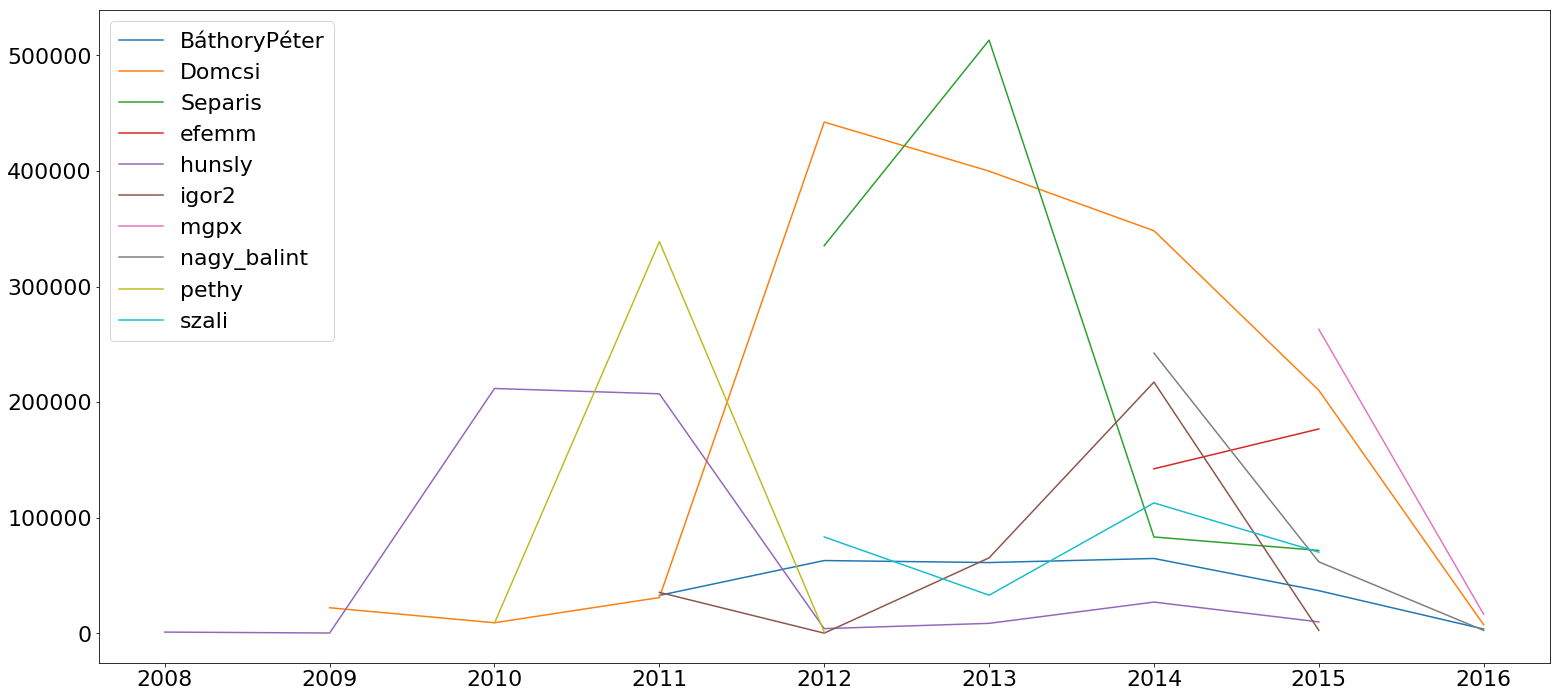

In [20]:
plt.figure(figsize=(26, 12))
for uid in np.unique(top10Users['user_sid']):
    plt.plot(top10Users[top10Users['user_sid']==uid].year, top10Users[top10Users['user_sid']==uid].node_count, label=uid )
plt.legend()    